In [5]:
import numpy as np
import tqdm.notebook as tqdm

import src

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
train_models = src.shapenet.get_shapenet_data("train")
np.random.shuffle(train_models)

In [3]:
nb_patches=2048

@tf.autograph.experimental.do_not_convert
def extract(path):
    cloud = src.shapenet.sample_points(path.decode("utf-8") , nb=100000)
    extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=1024)
    #extractor = src.dataset.PPFPatchExtractor(nb_patches=512, nb_points=256)
    ppf, M = extractor.make_example(cloud)
    return ppf, M

def _map(path):
    y = tf.numpy_function(extract, [path], (tf.float32, tf.float32))
    return y
dataset = tf.data.Dataset.from_tensor_slices(train_models)
dataset = dataset.map(_map, num_parallel_calls=16)#Will do it in parrallel 
dataset = dataset.batch(4)
dataset = dataset.prefetch(4)

In [6]:
ppfnet = src.pointnet.PPFNet()
optimizer = keras.optimizers.Adam(lr=0.001)
ppfnet.model.compile(optimizer=optimizer, loss=src.loss.N_tuple_loss(nb_patches))

In [7]:
ppfnet.model.fit(dataset)

   6/9204 [..............................] - ETA: 3:36:30 - loss: 1.0865e-06

KeyboardInterrupt: 

In [6]:
loss = []
pb = tqdm.tqdm(dataset)
for x,y in pb:
    res = ppfnet.model.train_on_batch(x,y)
    pb.set_description(f"loss {res:0.4}")
    pb.refresh() 
    loss.append(res)

failed to load image
Traceback (most recent call last):
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/exchange/obj.py", line 324, in parse_mtl
    file_data = resolver.get(split[1])
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/resolvers.py", line 84, in get
    with open(os.path.join(self.parent, name.strip()), 'rb') as f:
IsADirectoryError: [Errno 21] Is a directory: '/home/leo/Documents/PPFNet-tensorflow/data/ShapeNetCore.v2/04256520/191c92adeef9964c14038d588fd1342f/models/../'
failed to load image
Traceback (most recent call last):
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/exchange/obj.py", line 324, in parse_mtl
    file_data = resolver.get(split[1])
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/resolvers.py", line 84, in get
    with open(os.path.join(self.parent, name.strip()), 'rb') as f:
IsADirectoryError: [Errno 21] Is a directory: '/home/leo/Documents/PPFNet-tensorflow/data/ShapeNetCore.v2/042565

KeyboardInterrupt: 

In [8]:
#ppfnet.model.save_weights("models/test2")

In [8]:
import matplotlib.pyplot as plt

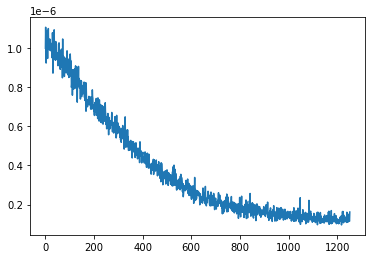

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss)

In [7]:
3

3